In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".XX"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
import jax.numpy as np
from jax.lib import xla_bridge
print("jax backend {}".format(xla_bridge.get_backend().platform))

import visualization
from SSN_classes import SSN2DTopoV1_ONOFF_local
from training import new_two_stage_training
from parameters import grid_pars, filter_pars, stimuli_pars, sig_pars, ssn_pars, conn_pars_m, conn_pars_s, ssn_layer_pars, conv_pars, training_pars, loss_pars

jax backend cpu


In [2]:
# Calculate find A and save
# BW_Grating(JiaGrating) is called 81 times and spatial_frequency is always 0.05235987755982988
ssn_mid = SSN2DTopoV1_ONOFF_local(
    ssn_pars=ssn_pars, # got c_E and c_I as new parameters
    grid_pars=grid_pars,
    conn_pars=conn_pars_m,
    filter_pars=filter_pars,
    J_2x2 = ssn_layer_pars.J_2x2_m,
    gE = ssn_layer_pars.gE_m, 
    gI = ssn_layer_pars.gE_s
)

ssn_pars.A = ssn_mid.A
if ssn_pars.phases == 4:
    ssn_pars.A2 = ssn_mid.A2

In [3]:
# Load orientation map, MJ
# ssn_ori_map = np.load(os.path.join(os.getcwd(), "ssn_map_uniform_good.npy"))

####################### TRAINING PARAMETERS #############################
epochs_to_save = np.insert(
    (np.unique(np.linspace(1, training_pars.epochs, training_pars.num_epochs_to_save).astype(int))), 0, 0
)

constant_ssn_pars = dict(
    ssn_pars=ssn_pars,
    grid_pars=grid_pars,
    conn_pars_m=conn_pars_m,
    conn_pars_s=conn_pars_s,
    gE=ssn_layer_pars.gE,
    gI=ssn_layer_pars.gI,
    filter_pars=filter_pars,
    conv_pars=conv_pars,# this got a lot of new stuff in it that might be a problem
    loss_pars=loss_pars,
    noise_type="poisson",
)


##################### SAVE RESULTS ###############################

# Name of results csv
home_dir = os.getcwd()

# Specify folder to save results
results_dir = os.path.join(
    home_dir,
    "results",
    "16-10",
    "phases_"
    + str(ssn_pars.phases)
    + "k_"
    + str(filter_pars.k)
    + "sigma_g"
    + str(filter_pars.sigma_g)
    + "gE_"
    + str(ssn_layer_pars.gE_m),
)

if os.path.exists(results_dir) == False:
    os.makedirs(results_dir)

# Specify results filename
run_dir = os.path.join(
    results_dir,
    "set_C_sig_noise_"
    + str(training_pars.sig_noise)
    + "_batch"
    + str(training_pars.batch_size)
    + "_lamw"
    + str(loss_pars.lambda_w),
)

# results_filename = None
results_filename = os.path.join(run_dir + "_results.csv")

In [4]:
########### TRAINING ############
from pycallgraph2 import PyCallGraph
from pycallgraph2.output import GraphvizOutput

with PyCallGraph(output=GraphvizOutput()):
    ([ssn_layer_pars, readout_pars],
        val_loss_per_epoch,
        training_losses,
        training_accs,
        train_sig_inputs,
        train_sig_outputs,
        val_sig_inputs,
        val_sig_outputs,
        epoch_c,
        save_w_sigs) = new_two_stage_training(
        ssn_layer_pars,
        sig_pars,
        training_pars,
        constant_ssn_pars,
        stimuli_pars,
        results_filename=results_filename,
        results_dir=run_dir,
        extra_stop=2,
        # ssn_ori_map=ssn_ori_map,
    )

New orientation map created for the middle layer.
Saving results to csv  c:\Users\jozsa\Desktop\Postdoc 2023-24\ABL-MJ\results\16-10\phases_2k_1.0471975511965976sigma_g0.1875gE_0.3\set_C_sig_noise_2.0_batch50_lamw1_results.csv
Training loss: 3.9475886821746826 ¦ Validation -- loss: 3.5643649101257324, true accuracy: 0.5600000023841858, at epoch 0, (time 79.94345712661743, 0.5480859279632568), 
Training accuracy: 0.4399999976158142, all losses[[2.1703365 ]
 [0.52472776]
 [0.5776564 ]
 [0.67486846]
 [0.        ]
 [3.9475887 ]]
Training loss: 3.7862391471862793 ¦ Validation -- loss: 3.753084421157837, true accuracy: 0.5199999809265137, at epoch 1, (time 74.15994715690613, 0.45571208000183105), 
Training loss: 3.91392183303833 ¦ Validation -- loss: 2.957106590270996, true accuracy: 0.6600000262260437, at epoch 3, (time 1.06557297706604, 0.4752945899963379), 
Entering second stage at epoch 3
Training loss: 4.035931587219238 ¦ Validation -- loss: 3.6598589420318604, true accuracy: 0.51999998

In [6]:
# Save training and validation losses
np.save(os.path.join(run_dir + "_training_losses.npy"), training_losses)
np.save(os.path.join(run_dir + "_validation_losses.npy"), val_loss_per_epoch)

In [7]:
results_plot_dir = os.path.join(run_dir + "_results")
visualization.plot_results_two_layers(
    results_filename, bernoulli=False, epoch_c=epoch_c, save=results_plot_dir
)

c:\Users\jozsa\Desktop\Postdoc 2023-24\ABL-MJ\visualization.py:261: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


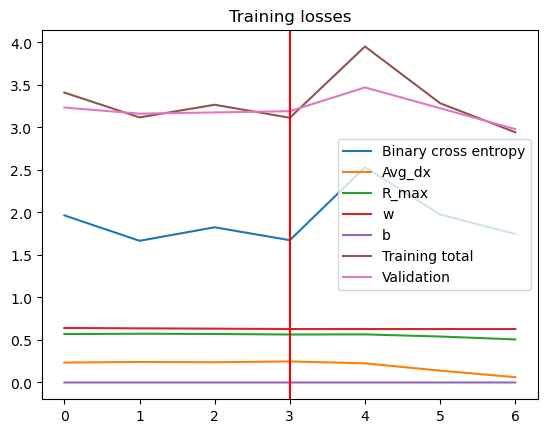

In [8]:
losses_dir = os.path.join(run_dir + "_losses")
visualization.plot_losses_two_stage(
    training_losses, val_loss_per_epoch, epoch_c=epoch_c, save=losses_dir, inset=False
)

In [9]:
# Plot sigmoid
sig_dir = os.path.join(run_dir + "_sigmoid")
visualization.plot_sigmoid_outputs(
    train_sig_input=train_sig_inputs,
    val_sig_input=val_sig_inputs,
    train_sig_output=train_sig_outputs,
    val_sig_output=val_sig_outputs,
    epoch_c=epoch_c,
    save=sig_dir,
)

c:\Users\jozsa\Desktop\Postdoc 2023-24\ABL-MJ\visualization.py:117: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


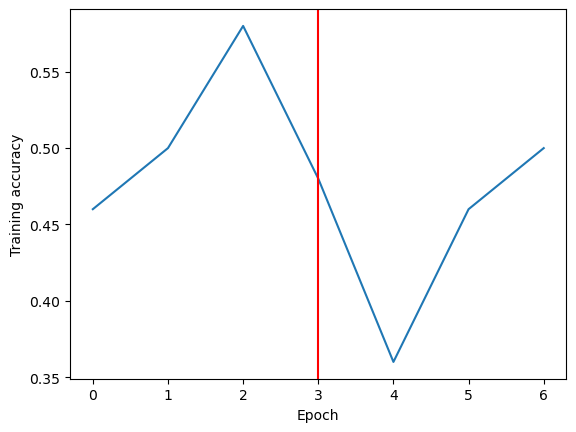

In [10]:
# Plot training_accs
training_accs_dir = os.path.join(run_dir + "_training_accs")
visualization.plot_training_accs(training_accs, epoch_c=epoch_c, save=training_accs_dir)

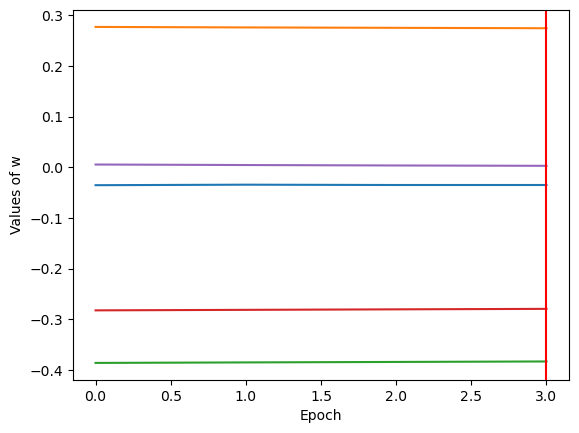

In [11]:
visualization.plot_w_sig(
        save_w_sigs,
        epochs_to_save[: len(save_w_sigs)],
        epoch_c,
        save=os.path.join(results_dir + "_w_sig_evolution"),
    )

# Deleted from new_two_stage_training but could not plot because r_refs is not an output # Plot maximum rates achieved during training
# visualization.plot_max_rates(r_refs, epoch_c=epoch_c, save=os.path.join(results_dir + "_max_rates"))
